## 4 Kernel Power on SVM and Regularized Logistic Regression {-}

In [132]:
import pickle
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from numpy.linalg import norm
from sklearn.svm import SVC


In [133]:
def plotClassifier(model, X, y):
    """plots the decision boundary of the model and the scatterpoints
       of the target values 'y'.

    Assumptions
    -----------
    y : it should contain two classes: '1' and '2'

    Parameters
    ----------
    model : the trained model which has the predict function

    X : the N by D feature array

    y : the N element vector corresponding to the target values

    """
    x1 = X[:, 0]
    x2 = X[:, 1]

    x1_min, x1_max = int(x1.min()) - 1, int(x1.max()) + 1
    x2_min, x2_max = int(x2.min()) - 1, int(x2.max()) + 1

    x1_line =  np.linspace(x1_min, x1_max, 200)
    x2_line =  np.linspace(x2_min, x2_max, 200)

    x1_mesh, x2_mesh = np.meshgrid(x1_line, x2_line)

    mesh_data = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    y_pred = model.predict(mesh_data)
    y_pred = np.reshape(y_pred, x1_mesh.shape)

    plt.figure()
    plt.xlim([x1_mesh.min(), x1_mesh.max()])
    plt.ylim([x2_mesh.min(), x2_mesh.max()])

    plt.contourf(x1_mesh, x2_mesh, -y_pred.astype(int), # unsigned int causes problems with negative sign... o_O
                cmap=plt.cm.RdBu, alpha=0.6)


    y_vals = np.unique(y)
    plt.scatter(x1[y==y_vals[0]], x2[y==y_vals[0]], color="b", label="class %+d" % y_vals[0])
    plt.scatter(x1[y==y_vals[1]], x2[y==y_vals[1]], color="r", label="class %+d" % y_vals[1])
    plt.legend()

### 4.1 {-}

In [134]:
# read in data and process
df = pd.read_csv('nonlineardata.csv', header=None, names=['x1', 'x2', 'y'])
X = df[['x1', 'x2']].to_numpy()
y = df[['y']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2022)


In [135]:
# fit data to soft margin svm with linear kernal 
lk_svm = SVC(kernel='linear', C=100)
lk_svm.fit(X_train, y_train.ravel())

SVC(C=100, kernel='linear')

SVM linear Kernal Performance:
training accuracy: 0.8125
testing accuracy: 0.7625


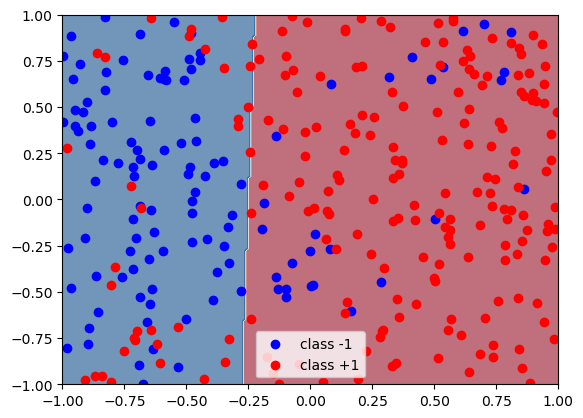

In [136]:
# get accuracy for training and test data
train_accuracy = lk_svm.score(X_train, y_train)
test_accuracy = lk_svm.score(X_test, y_test)
print("SVM linear Kernal Performance:")
print("training accuracy:",train_accuracy)
print("testing accuracy:", test_accuracy)


# plot decision boundry
plotClassifier(lk_svm, X_train, y_train.ravel())

### 4.2 {-}

In [137]:
# fit data to soft margin svm with polynomial kernal of degree 2
pk_svm = SVC(kernel='poly', degree=2, C=100)
pk_svm.fit(X_train, y_train.ravel())

SVC(C=100, degree=2, kernel='poly')

SVM polynomial (degree 2) Kernal Performance:
training accuracy: 0.634375
testing accuracy: 0.5875


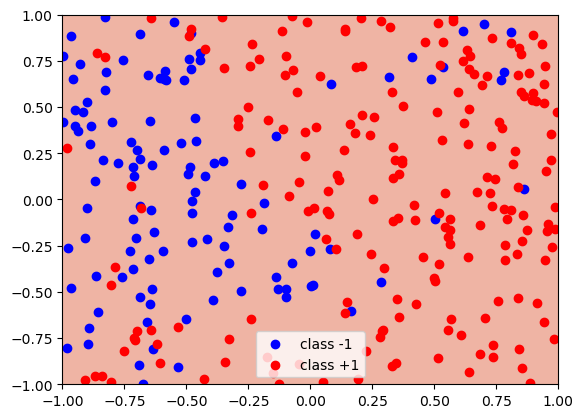

In [138]:
# get accuracy for training and test data
train_accuracy = pk_svm.score(X_train, y_train)
test_accuracy = pk_svm.score(X_test, y_test)
print("SVM polynomial (degree 2) Kernal Performance:")
print("training accuracy:",train_accuracy)
print("testing accuracy:", test_accuracy)

# plot decision boundry
plotClassifier(pk_svm, X_train, y_train.ravel())

### 4.3 {-}

In [139]:
# fit data to soft margin svm with gaussian kernal sigma = .5
sigma = .5
gamma = 1/(sigma**2)
gk_svm = SVC(kernel='rbf', gamma=gamma, C=100)
gk_svm.fit(X_train, y_train.ravel())

SVC(C=100, gamma=4.0)

SVM RBF Kernal Performance:
training accuracy: 0.9
testing accuracy: 0.85


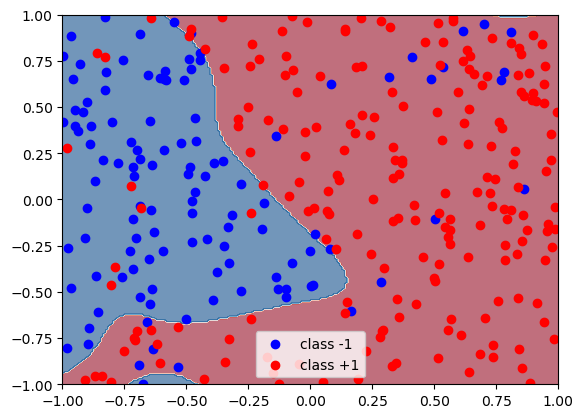

In [140]:
# get accuracy for training and test data
train_accuracy = gk_svm.score(X_train, y_train)
test_accuracy = gk_svm.score(X_test, y_test)
print("SVM RBF Kernal Performance:")
print("training accuracy:",train_accuracy)
print("testing accuracy:", test_accuracy)


# plot decision boundry
plotClassifier(gk_svm, X_train, y_train.ravel())

### 4.4 {-}

<function matplotlib.pyplot.show(close=None, block=None)>

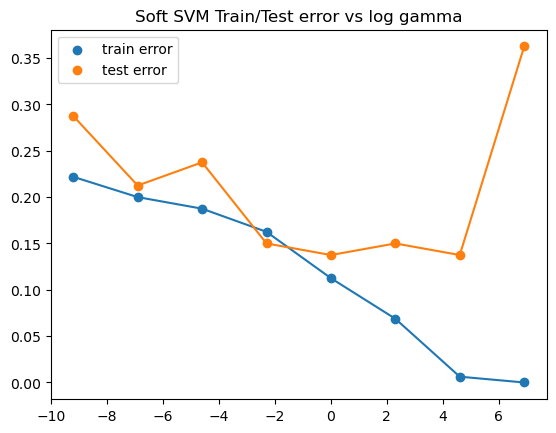

In [152]:

gamma = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
log_gamma = np.array([])
train_error = np.array([])
test_error = np.array([])
for g in gamma:
    svm = SVC(C=100, kernel='rbf', gamma=g)
    svm.fit(X_train, y_train.ravel())
    
    log_gamma = np.append(log_gamma, np.log(g))
    train_error = np.append(train_error, 1 - svm.score(X_train, y_train))
    test_error = np.append(test_error, 1 - svm.score(X_test, y_test))

train_error_scat = plt.scatter(log_gamma, train_error)
test_error_scat = plt.scatter(log_gamma, test_error)
plt.plot(log_gamma, train_error)
plt.plot(log_gamma, test_error)
plt.legend((train_error_scat, test_error_scat), ('train error', 'test error'))
plt.title("Soft SVM Train/Test error vs log gamma")

plt.show



### 4.5 {-}

In [142]:
def check_gradient(model, X, y, dimensionality, verbose=True):
    # This checks that the gradient implementation is correct
    w = np.random.rand(dimensionality)
    f, g = model.funObj(w, X, y)

    # Check the gradient
    estimated_gradient = approx_fprime(w,
                                       lambda w: model.funObj(w,X,y)[0],
                                       epsilon=1e-6)

    implemented_gradient = model.funObj(w, X, y)[1]

    if np.max(np.abs(estimated_gradient - implemented_gradient) > 1e-3):
        raise Exception('User and numerical derivatives differ:\n%s\n%s' %
             (estimated_gradient[:5], implemented_gradient[:5]))
    else:
        if verbose:
            print('User and numerical derivatives agree.')

In [143]:
def findMin(funObj, w, maxEvals, *args, verbose=0):
    """
    Uses gradient descent to optimize the objective function

    This uses quadratic interpolation in its line search to
    determine the step size alpha
    """
    # Parameters of the Optimization
    optTol = 1e-2
    gamma = 1e-4

    # Evaluate the initial function value and gradient
    f, g = funObj(w,*args)
    funEvals = 1

    alpha = 1.
    while True:
        # Line-search using quadratic interpolation to 
        # find an acceptable value of alpha
        gg = g.T.dot(g)

        while True:
            w_new = w - alpha * g
            f_new, g_new = funObj(w_new, *args)

            funEvals += 1
            if f_new <= f - gamma * alpha*gg:
                break

            if verbose > 1:
                print("f_new: %.3f - f: %.3f - Backtracking..." % (f_new, f))

            # Update step size alpha
            alpha = (alpha**2) * gg/(2.*(f_new - f + alpha*gg))

        # Print progress
        if verbose > 0:
            print("%d - loss: %.3f" % (funEvals, f_new))

        # Update step-size for next iteration
        y = g_new - g
        alpha = -alpha*np.dot(y.T,g) / np.dot(y.T,y)

        # Safety guards
        if np.isnan(alpha) or alpha < 1e-10 or alpha > 1e10:
            alpha = 1.

        if verbose > 1:
            print("alpha: %.3f" % (alpha))

        # Update parameters/function/gradient
        w = w_new
        f = f_new
        g = g_new

        # Test termination conditions
        optCond = norm(g, float('inf'))

        if optCond < optTol:
            if verbose:
                print("Problem solved up to optimality tolerance %.3f" % optTol)
            break

        if funEvals >= maxEvals:
            if verbose:
                print("Reached maximum number of function evaluations %d" % maxEvals)
            break

    return w, f

In [144]:
def log_1_plus_exp_safe(x):
    out = np.log(1+np.exp(x))
    out[x > 100] = x[x>100]
    out[x < -100] = np.exp(x[x < -100])
    return out

In [145]:
def kernel_RBF(X1, X2, gamma):
    # add sigma argument
    sigma = np.sqrt(1/gamma)
    K = np.zeros((X1.shape[0], X2.shape[0]))
    for j in range(X2.shape[0]):
        for i in range(X1.shape[0]):
            dif = X1[i] - X2[j]
            k = np.exp((-(norm(dif))**2)/sigma**2)
            K[i, j] = k 
    return K

def kernel_poly(X1, X2, p=2):
    K = (1 + X1@X2.T)**p
    return K

def kernel_linear(X1, X2):
    return X1@X2.T

In [146]:
class kernelLogRegL2():
    def __init__(self, lammy=1.0, verbose=0, maxEvals=100, kernel_fun=kernel_linear, **kernel_args):
        self.verbose = verbose
        self.lammy = lammy
        self.maxEvals = maxEvals
        self.kernel_fun = kernel_fun
        self.kernel_args = kernel_args

    def funObj(self, u, K, y):
        yKu = y * (K@u)

        # Calculate the function value
        # f = np.sum(np.log(1. + np.exp(-yKu)))
        f = np.sum(log_1_plus_exp_safe(-yKu))

        # Add L2 regularization
        f += 0.5 * self.lammy * u.T@K@u

        # Calculate the gradient value
        res = - y / (1. + np.exp(yKu))
        g = (K.T@res) + self.lammy * K@u

        return f, g


    def fit(self, X, y):
        n, d = X.shape
        self.X = X

        K = self.kernel_fun(X,X, **self.kernel_args)

        check_gradient(self, K, y, n, verbose=self.verbose)
        self.u, f = findMin(self.funObj, np.zeros(n), self.maxEvals, K, y, verbose=self.verbose)

    def predict(self, Xtest):
        Ktest = self.kernel_fun(Xtest, self.X, **self.kernel_args)
        return np.sign(Ktest@self.u)

/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


0.7625
0.7625


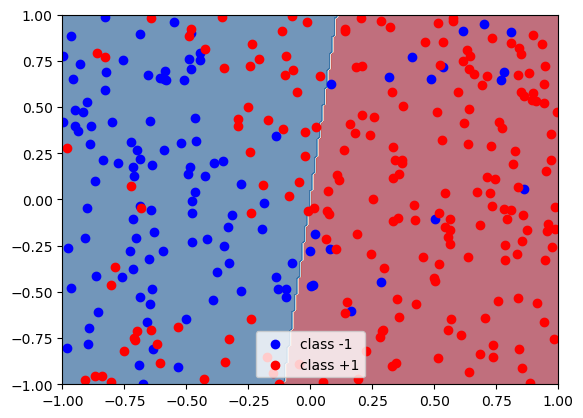

In [147]:
from sklearn.metrics import confusion_matrix
lklr = kernelLogRegL2(lammy=.01, kernel_fun=kernel_linear)
lklr.fit(X_train, y_train.ravel())
y_pred = lklr.predict(X_train)
conf_mat_train = confusion_matrix(y_train, y_pred)
accuracy_train = (conf_mat_train[0,0] + conf_mat_train[1,1]) / (np.sum(conf_mat_train))
print(accuracy_train)

y_pred = lklr.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_pred)
accuracy_test = (conf_mat_test[0,0] + conf_mat_test[1,1]) / (np.sum(conf_mat_test))
print(accuracy_test)

plotClassifier(lklr, X_train, y_train.ravel())


### 4.6 {-}

0.815625
0.7625


/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


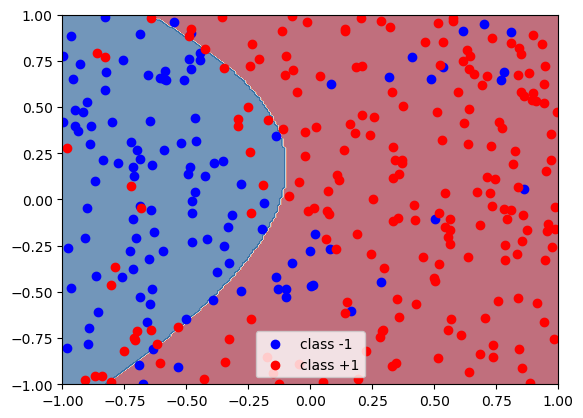

In [148]:
pklr = kernelLogRegL2(lammy=.01, kernel_fun=kernel_poly, **{'p':2})
pklr.fit(X_train, y_train.ravel())
y_pred = pklr.predict(X_train)
conf_mat_train = confusion_matrix(y_train, y_pred)
accuracy_train = (conf_mat_train[0,0] + conf_mat_train[1,1]) / (np.sum(conf_mat_train))
print(accuracy_train)

y_pred = pklr.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_pred)
accuracy_test = (conf_mat_test[0,0] + conf_mat_test[1,1]) / (np.sum(conf_mat_test))
print(accuracy_test)

plotClassifier(pklr, X_train, y_train.ravel())

### 4.7 {-}

/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


0.8875
0.85


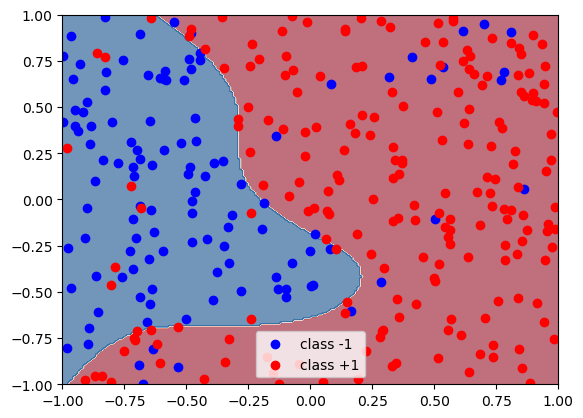

In [149]:
pklr = kernelLogRegL2(lammy=.01, kernel_fun=kernel_RBF, **{'gamma':4})
pklr.fit(X_train, y_train.ravel())
y_pred = pklr.predict(X_train)
conf_mat_train = confusion_matrix(y_train, y_pred)
accuracy_train = (conf_mat_train[0,0] + conf_mat_train[1,1]) / (np.sum(conf_mat_train))
print(accuracy_train)

y_pred = pklr.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_pred)
accuracy_test = (conf_mat_test[0,0] + conf_mat_test[1,1]) / (np.sum(conf_mat_test))
print(accuracy_test)

plotClassifier(pklr, X_train, y_train.ravel())

### 4.8 {-}

/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))
/var/folders/cp/v00lqnh10y93ymb6q9szklp40000gn/T/ipykernel_9455/470

<function matplotlib.pyplot.show(close=None, block=None)>

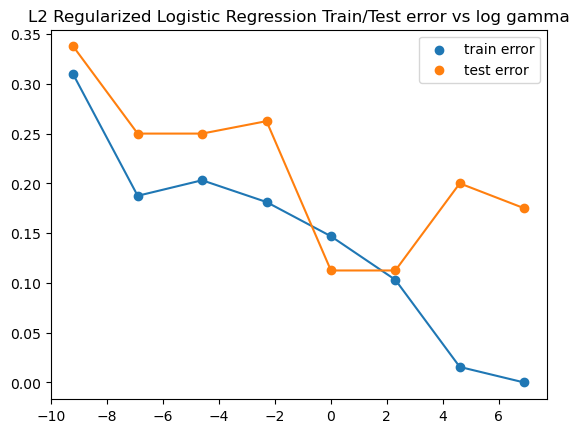

In [151]:
gamma = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
log_gamma = np.array([])
train_error = np.array([])
test_error = np.array([])
for g in gamma:
    pklr = kernelLogRegL2(lammy=.01, kernel_fun=kernel_RBF, **{'gamma':g})
    pklr.fit(X_train, y_train.ravel())


    y_pred = pklr.predict(X_train)
    conf_mat_train = confusion_matrix(y_train, y_pred)
    accuracy_train = (conf_mat_train[0,0] + conf_mat_train[1,1]) / (np.sum(conf_mat_train))

    y_pred = pklr.predict(X_test)
    conf_mat_test = confusion_matrix(y_test, y_pred)
    accuracy_test = (conf_mat_test[0,0] + conf_mat_test[1,1]) / (np.sum(conf_mat_test))
    
    log_gamma = np.append(log_gamma, np.log(g))
    train_error = np.append(train_error, 1 - accuracy_train)
    test_error = np.append(test_error, 1 - accuracy_test)


train_error_scat = plt.scatter(log_gamma, train_error)
test_error_scat = plt.scatter(log_gamma, test_error)
plt.plot(log_gamma, train_error)
plt.plot(log_gamma, test_error)
plt.legend((train_error_scat, test_error_scat), ('train error', 'test error'))
plt.title("L2 Regularized Logistic Regression Train/Test error vs log gamma")

plt.show
